This model will read data from a large set and Classify the Sentiment:
Positive, Negative, Natural

In [2]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
data = pd.read_csv('swiggy.csv')
data.head()


,ID,Area,City,Restaurant Price,Avg Rating,Total Rating,Food Item,Food Type,Delivery Time,Review
0,1,Suburb,Ahmedabad,600,4.2,6198,Sushi,Fast Food,30-40 min,"Good, but nothing extraordinary."
1,2,Business District,Pune,200,4.7,4865,Pepperoni Pizza,Non-Vegetarian,50-60 min,"Good, but nothing extraordinary."
2,3,Suburb,Bangalore,600,4.7,2095,Waffles,Fast Food,50-60 min,Late delivery ruined it.
3,4,Business District,Mumbai,900,4.0,6639,Sushi,Vegetarian,50-60 min,Best meal I've had in a while!
4,5,Tech Park,Mumbai,200,4.7,6926,Spring Rolls,Gluten-Free,20-30 min,Mediocre experience.


In [4]:
# Small code snippet for Tokenizer:

sentences = [
    'I am a good Boy', 
    'This is a good desk',
    'Boy is roaming around'
]

# Build vocab from the text data:
tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(sentences)

# View the word index (Vocab index)
word_index = tokenizer.word_index
word_index

# Convert orignal text to sequence
text_to_sequence = tokenizer.texts_to_sequences(sentences)
text_to_sequence

# pad_sequences: This function ensures that all sequences in a list have the same length, 
# which is a requirement for feeding data into a neural network.
padded_sequence = pad_sequences(text_to_sequence, padding = 'post')
padded_sequence


array([[ 5,  6,  1,  2,  3],
       [ 7,  4,  1,  2,  8],
       [ 3,  4,  9, 10,  0]], dtype=int32)

In [5]:
data = pd.read_csv('swiggy.csv')
data.head()

,ID,Area,City,Restaurant Price,Avg Rating,Total Rating,Food Item,Food Type,Delivery Time,Review
0,1,Suburb,Ahmedabad,600,4.2,6198,Sushi,Fast Food,30-40 min,"Good, but nothing extraordinary."
1,2,Business District,Pune,200,4.7,4865,Pepperoni Pizza,Non-Vegetarian,50-60 min,"Good, but nothing extraordinary."
2,3,Suburb,Bangalore,600,4.7,2095,Waffles,Fast Food,50-60 min,Late delivery ruined it.
3,4,Business District,Mumbai,900,4.0,6639,Sushi,Vegetarian,50-60 min,Best meal I've had in a while!
4,5,Tech Park,Mumbai,200,4.7,6926,Spring Rolls,Gluten-Free,20-30 min,Mediocre experience.


In [6]:
# Data Preprocessing:

data.shape
# (8000, 11)
# Drop the null rows:
data= data.dropna()
data.shape

# Cleaning and sentiment labeling:

data['Review'] = data['Review'].str.lower()
data['Review']

# good, but nothing extraordinary.
# Data still has many non-needed values we need to clear it:

data['Review'] = data['Review'].replace(r'[^a-z0-9\s]', '', regex = True)
data['Review'] = data['Review'].str.strip()
data['Review'] = data['Review'].replace(r'\s+', ' ', regex=True)
# good but nothing extraordinary

# Sentiment col adding 1 for > 3.5 and 0 otherwise
data['Sentiment'] = data['Avg Rating'].apply(lambda x: 1 if x > 3.5 else 0)
data['Sentiment']



# Check class distribution
print("\nClass distribution:")
print(data['Sentiment'].value_counts())
print(f"Class balance: {data['Sentiment'].value_counts(normalize=True)}")

# Remove empty reviews after cleaning
data = data[data['Review'].str.len() > 0]
print(f"\nFinal data shape: {data.shape}")



Class distribution:
Sentiment
1    5727
0    2273
Name: count, dtype: int64
Class balance: Sentiment
1    0.715875
0    0.284125
Name: proportion, dtype: float64

Final data shape: (8000, 11)


In [7]:
# Tokenize and pad the review data and extract the target sentiment:
# Tokenize: Converts text data to integer sequences
# Padding: Ensures all input sequences have the same length


max_features = 5000 #Sets the maximum number of words to keep in the tokenizer
max_length = 200 # Defines the fixed length for each input sequence after padding

# Initialize tokenizer with oov_token for unknown words

tokenizer = Tokenizer(num_words= max_features , oov_token='<OOV>')
tokenizer.fit_on_texts(data['Review'])
text_to_sequence= tokenizer.texts_to_sequences(data['Review'])


# [47, 10, 11, 48],
#  [47, 10, 11, 48],
#  [71, 9, 72, 3],

# Pad sequences (pre-padding by default, which is better for RNNs)
X = pad_sequences(text_to_sequence, maxlen=max_length, padding='pre', truncating='pre')
y = data['Sentiment'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Sample sequence length: {len(text_to_sequence[0])}")

X shape: (8000, 200)
y shape: (8000,)
Vocabulary size: 73
Sample sequence length: 4


In [8]:
# Splitting the data: Training, validation and test sets
# While mainting the class distribution

In [9]:
# The stratify parameter in scikit-learn's train_test_split function ensures that the resulting training and testing sets maintain 
# the same proportion of samples for each class as in the original dataset. 


# train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) : Splits data into 80% training and 20% test sets, preserving sentiment class balance
# train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train) : Further splits training data into 90% training and 10% validation sets, keeping class distribution consistent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42, stratify=y_train)

In [10]:
# RNN Modeling:
# 1. Architecting Model
# 2. Compile Model
# 3. Train Model
# 4. Evaluate Model
# 5. Test Model

In [11]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(output_dim = 128, input_dim=max_features, input_length = max_length))
# LSTM layer: Better than SimpleRNN for capturing long-term dependencies
# Dropout for regularization to prevent overfitting

model.add(tf.keras.layers.LSTM(units = 128, dropout = 0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(tf.keras.layers.Dense(units= 64, activation= 'relu'))
model.add(tf.keras.layers.Dropout((0.3)))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

c:\Users\thedo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

# Compile model with improved optimizer settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicit learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']  # Additional metrics for better evaluation
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks= [
    EarlyStopping(
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True,
        verbose = 1
    ),
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor=0.5,  # Reduce learning rate by half
        patience=2,
        min_lr=0.0001,
        verbose=1
    )
]

In [ ]:
history= model.fit(X_train, y_train, epochs= 10, validation_data = (X_val, y_val), batch_size = 32,
    callbacks=callbacks,verbose = 1)

score = model.evaluate(X_test,y_test, verbose=0)

print(f'Test Accuracy: {score[1]:.2f}')

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 89s 462ms/step - accuracy: 0.7149 - loss: 0.6039 - precision: 0.7163 - recall: 0.9966 - val_accuracy: 0.7156 - val_loss: 0.6102 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 84s 464ms/step - accuracy: 0.7160 - loss: 0.6012 - precision: 0.7160 - recall: 1.0000 - val_accuracy: 0.7156 - val_loss: 0.6027 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 85s 470ms/step - accuracy: 0.7160 - loss: 0.5997 - precision: 0.7160 - recall: 1.0000 - val_accuracy: 0.7156 - val_loss: 0.5982 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 91s 507ms/step - accuracy: 0.7160 - loss: 0.5986 - precision: 0.7160 - recall: 1.0000 - val_accuracy: 0.7156 - val_loss: 0.5989 - val_precision: 0.7156 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 92s 513ms/st

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       455
    Positive       0.72      1.00      0.83      1145

    accuracy                           0.72      1600
   macro avg       0.36      0.50      0.42      1600
weighted avg       0.51      0.72      0.60      1600


Confusion Matrix:
[[   0  455]
 [   0 1145]]


c:\Users\thedo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thedo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thedo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


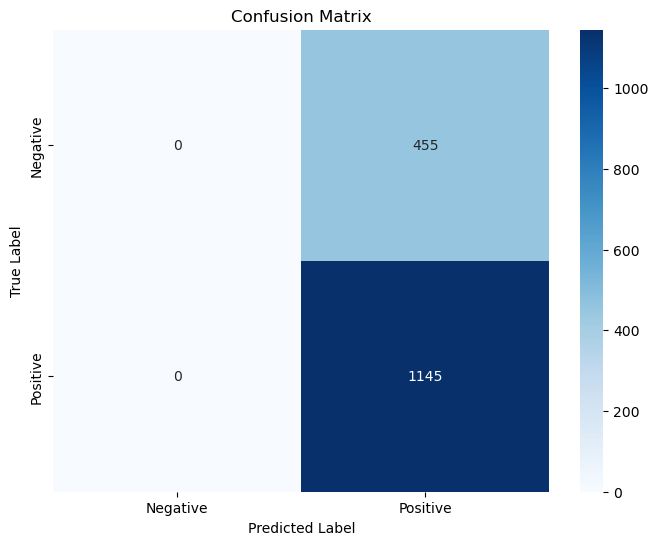

NameError: name 'history' is not defined

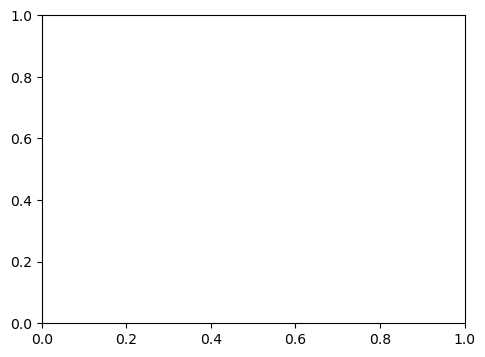

In [15]:
# Comprehensive Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [131]:
# Predict sentiments: We will create a function to preprocess a single review, predict its sentiment and display the result.
def make_prediction(review):
# Preprocess
    review = review.lower()
    review = re.sub(r'[^a-z0-9\s]', '', review)

# Tokenize
    seq = tokenizer.texts_to_sequences([review])

# Padding
    padded_seq = pad_sequences(seq, maxlen = max_length)

    prediction = model.predict(padded_seq)[0][0]

    return f"{'Positive' if prediction >= 0.5 else 'Negative'} (Probability: {prediction:.2f})"


review = 'I did not like the food'

make_prediction(review)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


'Positive (Probability: 0.69)'